In [1]:
# IMPORTS
import PGC
from scipy import signal
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# FONT SIZE FOR FIGURES
matplotlib.rcParams.update({'font.size': 14})

In [3]:
# PARAMETERS

# Time parameters
time_step = 1e-3
time_max = int(1e2)-time_step

# Number of trials
num_trials = int(1e3)

# Number of bootstrap iterations
num_boot_iter = 10

# Frequency for time processes
f0 = 10;

# Scales for Rayleigh RVs for X, W, and Z amplitude
X_scale = 1
W_scale = 1
Z_scale = 1

In [4]:
# GENERATE TIME (include time_max in time by adding one additional time_step)
time = np.arange(0,time_max+time_step,time_step)
time_array = npm.repmat(time[:, None].T,num_trials,1)

In [5]:
# GENERATE THREE PROCESSES
# First generate random amplitudes
X_amp = npm.repmat(np.random.rayleigh(X_scale,(num_trials,1)),1,len(time))
W_amp = npm.repmat(np.random.rayleigh(W_scale,(num_trials,1)),1,len(time))
Z_amp = npm.repmat(np.random.rayleigh(Z_scale,(num_trials,1)),1,len(time))

# Next generate random phases
X_phase = npm.repmat(2*math.pi*np.random.uniform(size=(num_trials,1)),1,len(time))
W_phase = npm.repmat(2*math.pi*np.random.uniform(size=(num_trials,1)),1,len(time))
Z_phase = npm.repmat(2*math.pi*np.random.uniform(size=(num_trials,1)),1,len(time))

# Now generate random processes
X = X_amp*np.cos((2*math.pi*f0*time_array)+X_phase)
#W = np.sqrt(0.5)*X+np.sqrt(0.5)*W_amp*np.cos((2*math.pi*f0*time_array)+W_phase)
#Z = np.sqrt(0.5)*W+np.sqrt(0.5)*Z_amp*np.cos((2*math.pi*f0*time_array)+Z_phase)
W = X+W_amp*np.cos((2*math.pi*f0*time_array)+W_phase)
Z = W+Z_amp*np.cos((2*math.pi*f0*time_array)+Z_phase)

X = X + (0.001)*np.random.normal(size=(X_phase.shape))
W = W + (0.001)*np.random.normal(size=(X_phase.shape))
Z = Z + (0.001)*np.random.normal(size=(X_phase.shape))

In [6]:
# PLOT X
#f, ax = plt.subplots(figsize=(15, 6));
#plt.plot(time,X.T);

#plt.xlim((0,10));
#plt.title('X');

In [7]:
# PLOT W
#f, ax = plt.subplots(figsize=(15, 6));
#plt.plot(time,W.T);

#plt.xlim((0,10));
#plt.title('W');

In [8]:
# PLOT Z
#f, ax = plt.subplots(figsize=(15, 6));
#plt.plot(time,Z.T);

#plt.xlim((0,10));
#plt.title('Z');

In [9]:
# PLOT Y
#f, ax = plt.subplots(figsize=(15, 6));
#plt.plot(time,Y.T);

#plt.xlim((0,10));
#plt.title('Y');

In [10]:
# ESTIMATE COH, PCOH, MIF, & PGC
data = np.stack((X,W,Z),axis=0)
f = np.fft.fftfreq(len(time),time_step)

f_of_interest = np.where(f0==f)[0][0]

P, C = PGC.pcoh(data,time_step,time_max)
C[np.eye(C.shape[0]).astype(bool)]=0
P[np.eye(P.shape[0]).astype(bool)]=0

MIF = PGC.pgc(data,num_boot_iter,f_of_interest)
PGC = PGC.pgc(data,num_boot_iter,f_of_interest,f_of_interest,f_of_interest)

Tester = Classifier, metric = donsker_varadhan



Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan
Tester = Classifier, metric = donsker_varadhan


In [11]:
# LOG TRANSFORMATION OF COHERENCE & PARTIAL COHERENCE
C_log = -np.log(1-C)
P_log = -np.log(1-P)

In [12]:
spectral_matrix = np.zeros((3,3))
spectral_matrix[0,1] = np.log(1+((X_scale**2)/(W_scale**2)))
spectral_matrix[1,0] = spectral_matrix[0,1]
spectral_matrix[1,2] = np.log(1+(((X_scale**2)+(W_scale**2))/(Z_scale**2)))
spectral_matrix[2,1] = spectral_matrix[1,2]
spectral_matrix[0,2] = np.log(1+((X_scale**2)/((Z_scale**2)+(W_scale**2))))
spectral_matrix[2,0] = spectral_matrix[0,2]

In [13]:
# TRUE MIF VALUES
MIF_true = np.zeros((data.shape[0],data.shape[0]))
MIF_true[0,1] = np.log(1+((X_scale**2)/(W_scale**2)))
MIF_true[1,0] = MIF_true[0,1]
MIF_true[1,2] = np.log(1+(((X_scale**2)+(W_scale**2))/(Z_scale**2)))
MIF_true[2,1] = MIF_true[1,2]
MIF_true[0,2] = np.log(1+((X_scale**2)/((Z_scale**2)+(W_scale**2))))
MIF_true[2,0] = MIF_true[0,2]

In [14]:
# TRUE PGC
from scipy.linalg import fractional_matrix_power
S_mat = 0.5*np.asarray([[1,1,1],[1,2,2],[1,2,3]])
S_mat_inv = np.linalg.inv(S_mat)
denom = npm.repmat(np.diag(S_mat_inv),3,1)*(npm.repmat(np.diag(S_mat_inv),3,1).T)
P_mat = -S_mat_inv/np.sqrt(denom)
PGC_true = -np.log(1-(P_mat)**2)
PGC_true[0,0]=0
PGC_true[1,1]=0
PGC_true[2,2]=0
PGC_true

/home/joe/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


array([[ 0.        ,  0.28768207, -0.        ],
       [ 0.28768207,  0.        ,  0.69314718],
       [-0.        ,  0.69314718,  0.        ]])

In [15]:
# SELECT FREQUENCY RANGE
f_ind = np.arange(2000).astype(int)

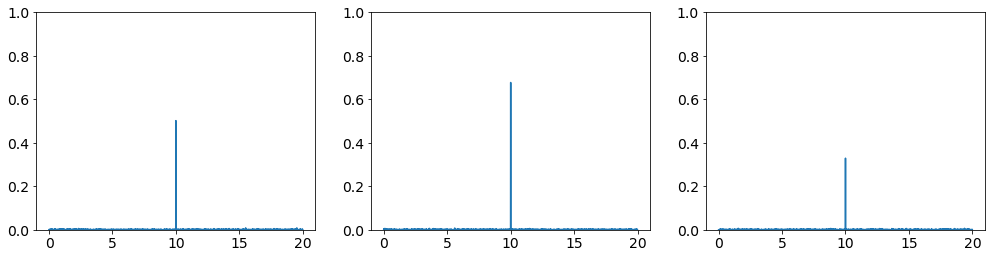

In [16]:
# PLOT RESULTS
f_plt, ax = plt.subplots(figsize=(17, 4));

plt.subplot(131)
plt.plot(f[f_ind],C[0,1,f_ind])
plt.ylim((0,1))

plt.subplot(132)
plt.plot(f[f_ind],C[1,2,f_ind])
plt.ylim((0,1))

plt.subplot(133)
plt.plot(f[f_ind],C[0,2,f_ind])
plt.ylim((0,1));

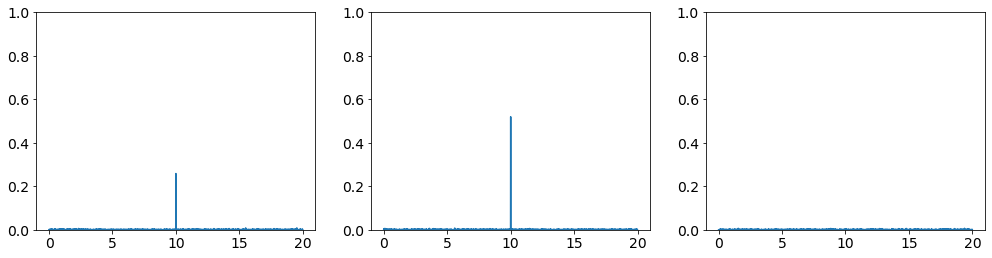

In [17]:
# PLOT RESULTS
f_plt, ax = plt.subplots(figsize=(17, 4));

plt.subplot(131)
plt.plot(f[f_ind],P[0,1,f_ind])
plt.ylim((0,1))

plt.subplot(132)
plt.plot(f[f_ind],P[1,2,f_ind])
plt.ylim((0,1))

plt.subplot(133)
plt.plot(f[f_ind],P[0,2,f_ind])
plt.ylim((0,1));

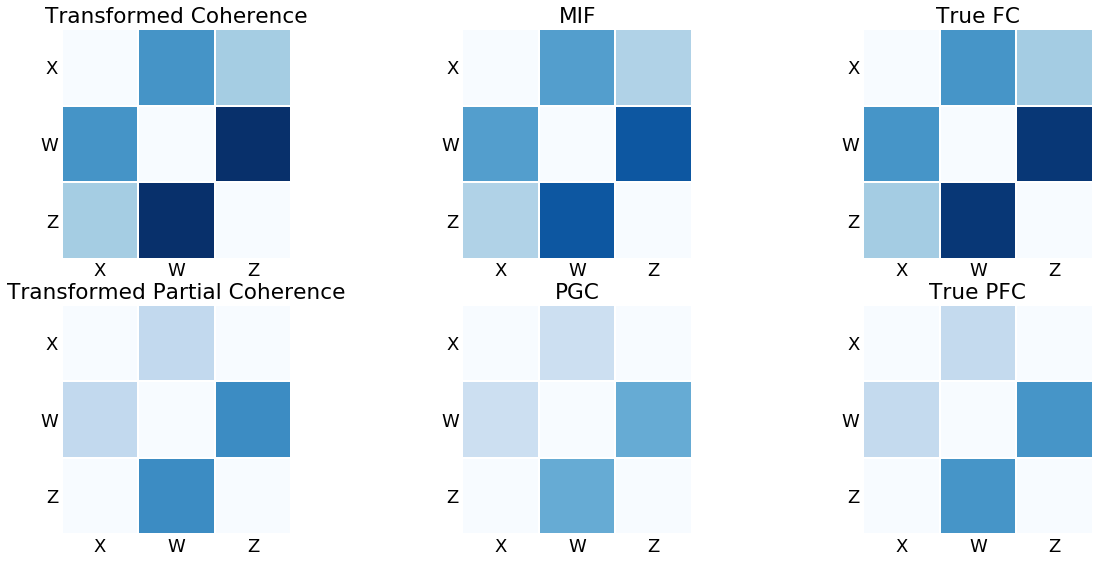

In [18]:
# PLOT RESULTS

# FONT SIZE FOR FIGURES
matplotlib.rcParams.update({'font.size': 18})

f_plt, ax = plt.subplots(figsize=(17, 8));
f_plt.tight_layout()

lw=1
max_val = np.max(np.stack((MIF_true,PGC_true,MIF,PGC,np.squeeze(C_log[:,:,f==f0]),
                           np.squeeze(P_log[:,:,f==f0]))))

ax = plt.subplot(231)
sns.heatmap(np.squeeze(C_log[:,:,f==f0]),square=True,cmap="Blues",vmax=max_val,vmin=0,
            linewidths=lw,cbar=False)
plt.title('Transformed Coherence')
plt.xticks([0.5,1.5,2.5],['X','W','Z'])
plt.yticks([0.5,1.5,2.5],['X','W','Z'],rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)

ax = plt.subplot(234)
sns.heatmap(np.squeeze(P_log[:,:,f==f0]),square=True,cmap="Blues",vmax=max_val,vmin=0,
            linewidths=lw,cbar=False)
plt.title('Transformed Partial Coherence')
plt.xticks([0.5,1.5,2.5],['X','W','Z'])
plt.yticks([0.5,1.5,2.5],['X','W','Z'],rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)

ax = plt.subplot(232)
sns.heatmap(MIF,square=True,cmap="Blues",vmax=max_val,vmin=0,
            linewidths=lw,cbar=False)
plt.title('MIF')
plt.xticks([0.5,1.5,2.5],['X','W','Z'])
plt.yticks([0.5,1.5,2.5],['X','W','Z'],rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)

ax = plt.subplot(235)
sns.heatmap(PGC,square=True,cmap="Blues",vmax=max_val,vmin=0,
            linewidths=lw,cbar=False)
plt.title('PGC')
plt.xticks([0.5,1.5,2.5],['X','W','Z'])
plt.yticks([0.5,1.5,2.5],['X','W','Z'],rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)

ax = plt.subplot(233)
sns.heatmap(MIF_true,square=True,cmap="Blues",vmax=max_val,vmin=0,
            linewidths=lw,cbar=False)
plt.title('True FC')
plt.xticks([0.5,1.5,2.5],['X','W','Z'])
plt.yticks([0.5,1.5,2.5],['X','W','Z'],rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)

ax = plt.subplot(236)
sns.heatmap(PGC_true,square=True,cmap="Blues",vmax=max_val,vmin=0,
            linewidths=lw,cbar=False)
plt.title('True PFC')
plt.xticks([0.5,1.5,2.5],['X','W','Z'])
plt.yticks([0.5,1.5,2.5],['X','W','Z'],rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0);

plt.savefig('figure3.pdf');
#plt.savefig('figure3_colorbar.pdf');

In [19]:
from scipy.io import savemat
data_to_save = {"C_log": C_log, "P_log": P_log, 
        "MIF": MIF, "PGC":PGC, "MIF_true":MIF_true, "PGC_true":PGC_true }
savemat("data.mat", data_to_save)